In [ ]:
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn import datasets
from sklearn.datasets import fetch_california_housing
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import inv_boxcox
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import SplineTransformer

**Eduson**

In [20]:
X, Y = datasets.fetch_california_housing(as_frame=True, return_X_y=True)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
print(X_train.shape, X_test.shape)

(18576, 8) (2064, 8)


In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train= pd.DataFrame(scaler.transform(X_train), columns=scaler.get_feature_names_out())
X_test = pd.DataFrame(scaler.transform( X_test), columns=scaler.get_feature_names_out())
print(X_train.shape, X_test.shape)

In [ ]:

num_features = X.shape[1]
for i in range(num_features):
    column = X.columns[i]
    X_train[f"{column}_squared"] = X_train[column] ** 2
    X_test[f"{column}_squared"] = X_test[column] ** 2
    X_train[f"{column}_cubed"] = X_train[column] ** 3
    X_test[f"{column}_cubed"] = X_test[column] ** 3
    X_train[f"{column}_log"] = np.log(10 + X_train[column])
    X_test[f"{column}_log"] = np.log(10 + X_test[column])

    for j in range(i + 1, num_features):
        other_column = X.columns[j]
        X_train[f"{column}_x_{other_column}"] = X_train[column] * X_train[other_column]
        X_test[f"{column}_x_{other_column}"] = X_test[column] * X_test[other_column]

print(X_train.shape, X_test.shape)
print(X_train.columns)
print(X_test.columns)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train= pd.DataFrame(scaler.transform(X_train), columns=scaler.get_feature_names_out())
X_test = pd.DataFrame(scaler.transform( X_test), columns=scaler.get_feature_names_out())

In [ ]:
model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

print(f"Train MSE: {metrics.mean_squared_error(Y_train, model.predict(X_train)):.3}")
print(f"Test MSE: {metrics.mean_squared_error(Y_test, model.predict(X_test)):.3}")


In [77]:
p = pd.cut(X.AveBedrms[:50], bins=3)
p.describe()
p.unique()
y = Y[:50]

In [28]:
X.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

In [80]:
sns.histplot(data=X)

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000001C2B29F5DA0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001C2BC0C8B80> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

**Регрессионный анализ scipy.stats**
* `p_value` для `slope` / `coef` / `wight`

In [ ]:
for column in X_train.columns: 
    feature = X_train[column]
    slope, intercept, r_value, p_value, std_err = stats.linregress(feature, Y_train)
    
    print(f'{column} p_value : {p_value}')

    
# print(slope)
# print(intercept)
# print(r_value,)
# print(p_value)
# print(std_err)



**VIF**
* VIF (фактор инфляции дисперсии) — это статистика, которая измеряет уровень `мультиколлинеарности` между `признаками` в `регрессионной модели`.

VIF	Интерпретация
* `1`	Нет корреляции между данным признаком и другими
* `1–5`	Умеренная корреляция, приемлемо
* `5–10`	Высокая корреляция, нужно насторожиться
* `> 10`	Очень высокая мультиколлинеарность — признак мешает модели

In [ ]:
X_vif = add_constant(X) # добавляем константу (intercept)
type(X_vif)

vif_data = pd.DataFrame() # Пустой DataFrame

vif_data['feature_vif'] = X_vif.columns # Записываем имена столбцов в колонку VIF

vif_data

vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

vif_data

**SplineTransformer + Ridge в пайплайне**

In [14]:
X, Y = datasets.fetch_california_housing(as_frame=True, return_X_y=True)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
print(X_train.shape, X_test.shape)

(18576, 8) (2064, 8)


In [15]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train= pd.DataFrame(scaler.transform(X_train), columns=scaler.get_feature_names_out())
X_test = pd.DataFrame(scaler.transform( X_test), columns=scaler.get_feature_names_out())


**Параметры	SplineTransformer** 
* `degree=3`	Кубические сплайны
* `n_knots=5`	Количество узлов ⇒ определяет гибкость (как много кусочков у кривой)
* `include_bias=False`	Убирает константу, если она уже есть в модели

In [16]:
# Пайплайн: сначала сплайны, потом линейная модель
model = make_pipeline(
    SplineTransformer(degree=3, n_knots=5, include_bias=False),
    Ridge(alpha=1.0)
)

# Обучение
model.fit(X_train, Y_train)

# Оценка
y_pred = model.predict(X_test)
print(f"MSE: {mean_squared_error(Y_test, y_pred):.3f}")

MSE: 0.504


(100, 6)


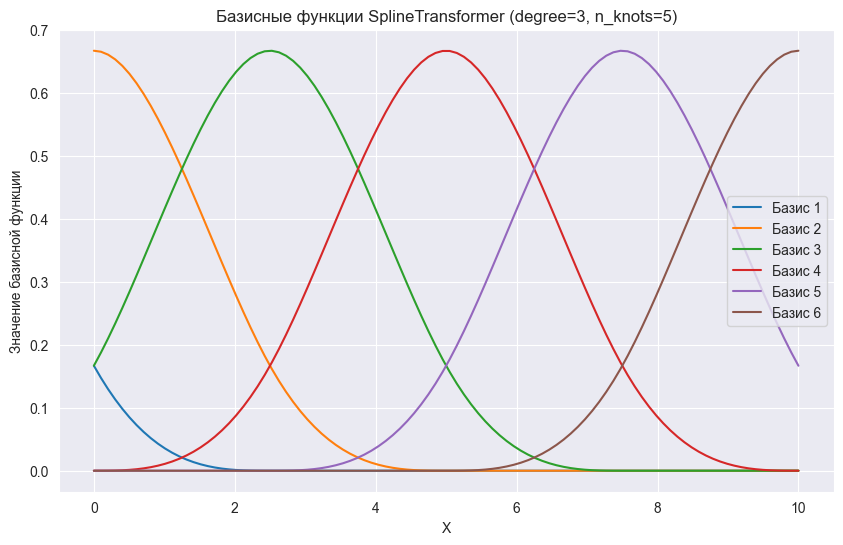

In [19]:
# Исходные данные — числовой признак
X = np.linspace(0, 10, 100).reshape(-1, 1)

# Создаём трансформер: кубический сплайн с 5 узлами, без bias
spline = SplineTransformer(degree=3, n_knots=5, include_bias=False)

# Применяем трансформацию
X_spline = spline.fit_transform(X)
print(X_spline.shape)


# Визуализируем базисные функции сплайнов
plt.figure(figsize=(10, 6))
for i in range(X_spline.shape[1]):
    plt.plot(X, X_spline[:, i], label=f'Базис {i+1}')
plt.title('Базисные функции SplineTransformer (degree=3, n_knots=5)')
plt.xlabel('X')
plt.ylabel('Значение базисной функции')
plt.legend()
plt.show()